cpu


c:\Users\Sathwik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sathwik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cpu
Epoch [1/200], Train Loss: 4.6779, Train Acc: 0.0625, Test Loss: 3.1234, Test Acc: 0.3611
Epoch [2/200], Train Loss: 2.6859, Train Acc: 0.3542, Test Loss: 2.2344, Test Acc: 0.5278
Epoch [3/200], Train Loss: 2.1286, Train Acc: 0.5625, Test Loss: 1.7070, Test Acc: 0.6111
Epoch [4/200], Train Loss: 1.7873, Train Acc: 0.7014, Test Loss: 1.3547, Test Acc: 0.8056
Epoch [5/200], Train Loss: 1.4849, Train Acc: 0.8194, Test Loss: 1.0277, Test Acc: 0.8056
Epoch [6/200], Train Loss: 1.3158, Train Acc: 0.8542, Test Loss: 0.8353, Test Acc: 0.8333
Epoch [7/200], Train Loss: 0.9998, Train Acc: 0.9583, Test Loss: 0.6920, Test Acc: 0.8056
Epoch [8/200], Train Loss: 0.8957, Train Acc: 0.9375, Test Loss: 0.6335, Test Acc: 0.8611
Epoch [9/200], Train Loss: 0.6289, Train Acc: 1.0000, Test Loss: 0.5335, Test Acc: 0.8611
Epoch [10/200], Train Loss: 0.7664, Train Acc: 0.9028, Test Loss: 0.4530, Test Acc: 0.9167
Epoch [11/200], Train Loss: 0.7359, Train Acc: 0.8889, Test Loss: 0.4303, Test Acc: 0.9167
Epoc

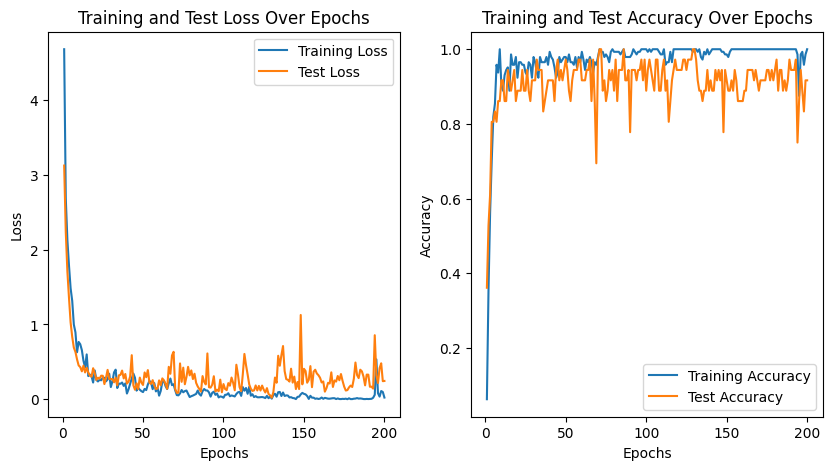

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set a random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Define paths and parameters
data_dir = r"E:\Woxsen\SEM - 6\Minor project\DATA COPY OT"
image_size = 404
num_classes = 15
num_shots = 2
num_query_samples = 10
batch_size = 2
num_epochs = 200
learning_rate = 0.0001

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for idx, cls in enumerate(self.classes)}
        self.samples = self.load_samples()

    def load_samples(self):
        samples = []
        for cls in self.classes:
            class_path = os.path.join(self.data_dir, cls)
            # Use glob to get a list of files
            images = glob(os.path.join(class_path, '*'))
            for img in images:
                samples.append((img, self.class_to_idx[cls]))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# Split dataset into train and test sets
def split_dataset(dataset, test_size=0.2):
    num_samples = len(dataset)
    indices = list(range(num_samples))
    split = int(np.floor(test_size * num_samples))
    random.shuffle(indices)
    train_indices, test_indices = indices[split:], indices[:split]
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)
    return train_dataset, test_dataset

# Set up data transforms
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Create the dataset
dataset = CustomDataset(data_dir, transform=transform)

# Split dataset into train and test sets
train_dataset, test_dataset = split_dataset(dataset, test_size=0.2)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Define Prototypical Network model
class PrototypicalNet(nn.Module):
    def __init__(self, num_classes, feature_dim=512, model_name='densenet121'):
        super(PrototypicalNet, self).__init__()  # Use double underscores for __init__
        if model_name.startswith('resnet'):
            self.encoder = models.__dict__[model_name](pretrained=True)
            in_features = self.encoder.fc.in_features
            self.encoder.fc = nn.Identity()
        elif model_name.startswith('densenet'):
            self.encoder = models.__dict__[model_name](pretrained=True)
            in_features = self.encoder.classifier.in_features
            self.encoder.classifier = nn.Identity()
        elif model_name.startswith('vgg'):
            self.encoder = models.__dict__[model_name](pretrained=True)
            in_features = self.encoder.classifier[6].in_features
            self.encoder.classifier = nn.Identity()
        else:
            raise NotImplementedError("Model not supported")

        self.fc = nn.Linear(in_features, feature_dim)
        self.prototypes = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Initialize the Prototypical Network model
model1 = PrototypicalNet(num_classes).to(device)
print(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model1.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Evaluation on test dataset
    model1.eval()
    epoch_test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()
            _, predicted_test = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()

    epoch_test_loss /= len(test_loader)
    test_losses.append(epoch_test_loss)

    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

# Calculate overall accuracy for training dataset
overall_train_accuracy = sum(train_accuracies) / len(train_accuracies)

# Calculate overall accuracy for test dataset
overall_test_accuracy = sum(test_accuracies) / len(test_accuracies)

print(f"Overall Training Accuracy: {overall_train_accuracy:.4f}")
print(f"Overall Test Accuracy: {overall_test_accuracy:.4f}")

# Plotting
plt.figure(figsize=(10, 5))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses,  label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies,  label='Test Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Test Cases

In [3]:
# Set the model to evaluation mode
model1.eval()

# Lists to store actual and predicted labels
actual_labels = []
predicted_labels = []

# Iterate through the test loader
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model1(images)
        
        # Get predicted labels
        _, predicted = torch.max(outputs, 1)
        
        # Append actual and predicted labels
        actual_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
actual_labels = np.array(actual_labels)
predicted_labels = np.array(predicted_labels)

# Print actual and predicted labels for each image
for i in range(len(actual_labels)):
    print(f"Image {i+1}: Actual - {actual_labels[i]}, Predicted - {predicted_labels[i]}")


Image 1: Actual - 14, Predicted - 14
Image 2: Actual - 4, Predicted - 4
Image 3: Actual - 1, Predicted - 1
Image 4: Actual - 3, Predicted - 3
Image 5: Actual - 1, Predicted - 1
Image 6: Actual - 3, Predicted - 13
Image 7: Actual - 5, Predicted - 5
Image 8: Actual - 10, Predicted - 10
Image 9: Actual - 5, Predicted - 5
Image 10: Actual - 1, Predicted - 1
Image 11: Actual - 5, Predicted - 5
Image 12: Actual - 2, Predicted - 2
Image 13: Actual - 12, Predicted - 12
Image 14: Actual - 0, Predicted - 0
Image 15: Actual - 9, Predicted - 9
Image 16: Actual - 10, Predicted - 7
Image 17: Actual - 9, Predicted - 9
Image 18: Actual - 13, Predicted - 13
Image 19: Actual - 14, Predicted - 14
Image 20: Actual - 5, Predicted - 5
Image 21: Actual - 7, Predicted - 7
Image 22: Actual - 14, Predicted - 14
Image 23: Actual - 2, Predicted - 2
Image 24: Actual - 7, Predicted - 7
Image 25: Actual - 10, Predicted - 10
Image 26: Actual - 12, Predicted - 12
Image 27: Actual - 14, Predicted - 14
Image 28: Actual 

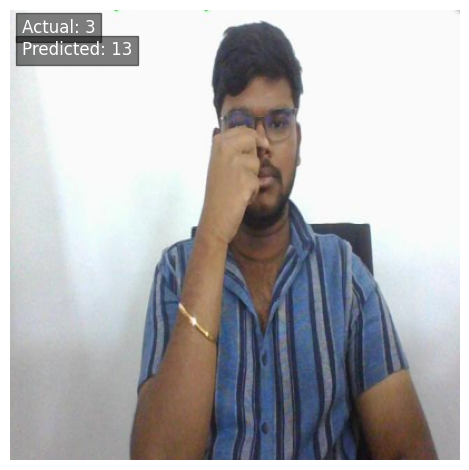

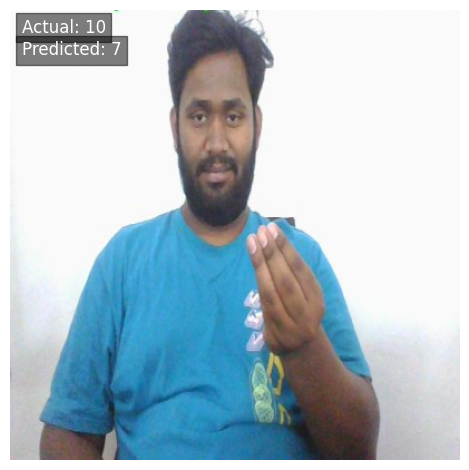

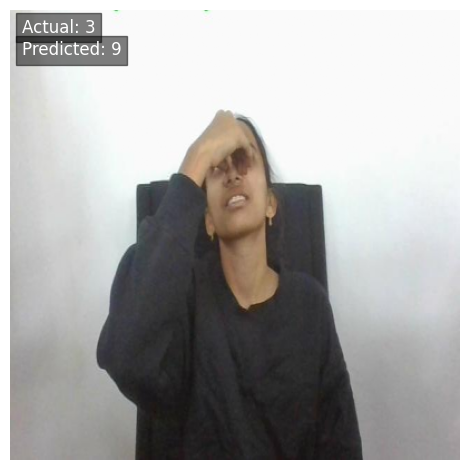

In [9]:
# Set the model to evaluation mode
model1.eval()

# Lists to store actual and predicted labels
actual_labels = []
predicted_labels = []

# Iterate through the test loader
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model1(images)
        
        # Get predicted labels
        _, predicted = torch.max(outputs, 1)
        
        # Append actual and predicted labels
        actual_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
actual_labels = np.array(actual_labels)
predicted_labels = np.array(predicted_labels)

# Find indices of wrong predictions
wrong_prediction_indices = np.where(actual_labels != predicted_labels)[0]

# Print images with wrong predictions
for idx in wrong_prediction_indices:
    images, actual_label = test_dataset[idx]
    predicted_label = predicted_labels[idx]
    output_image = generate_output_image(images, actual_label, predicted_label)
    plt.show()


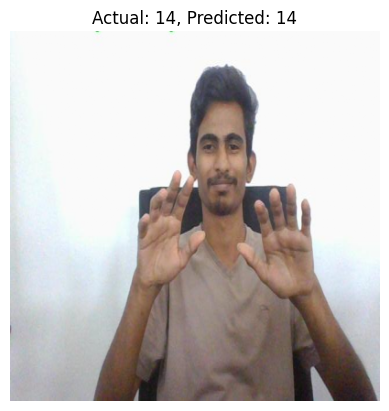

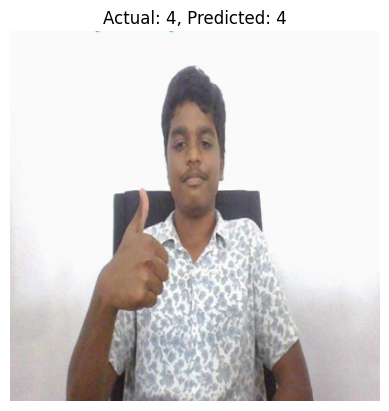

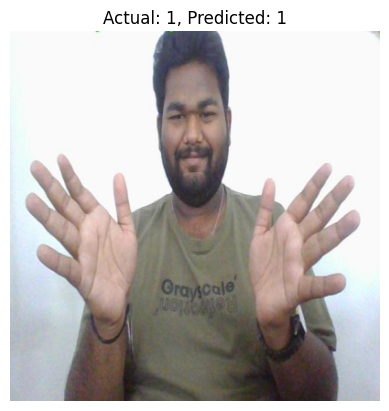

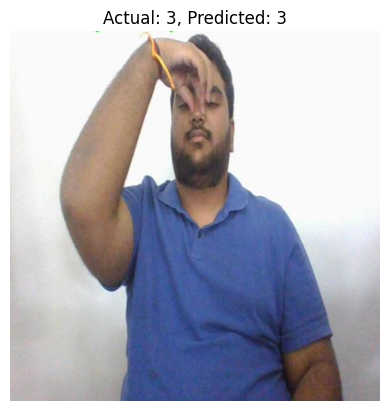

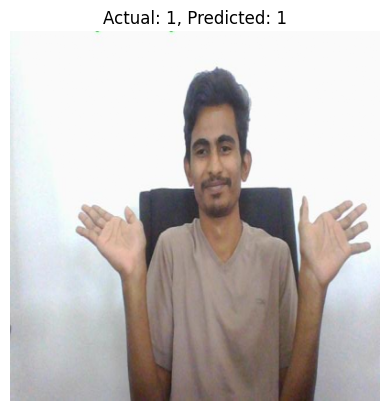

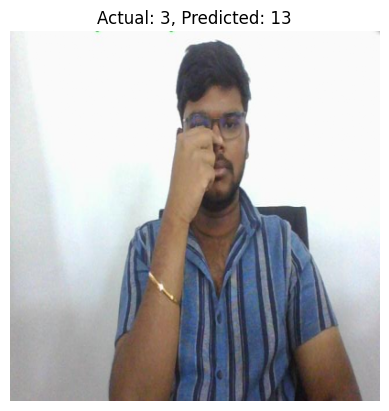

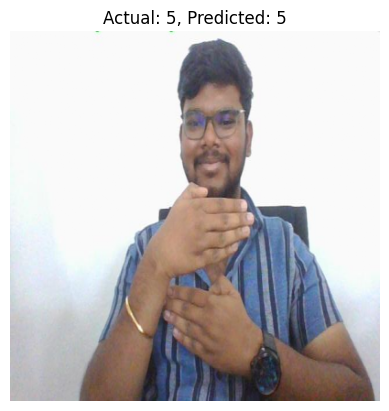

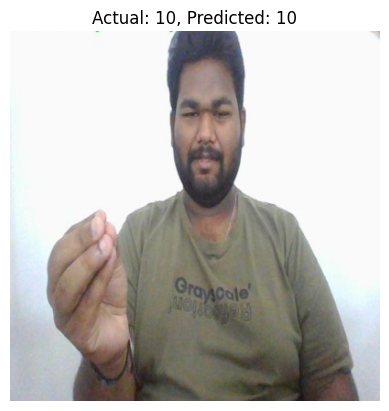

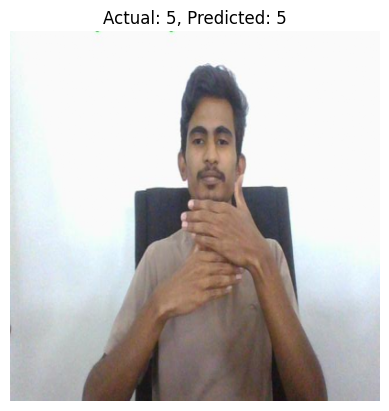

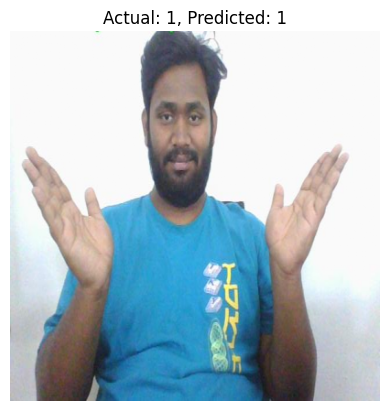

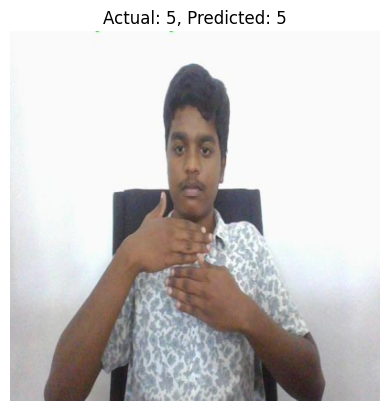

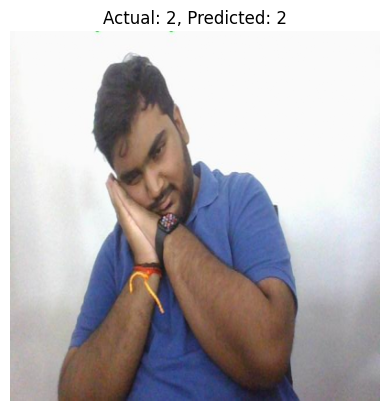

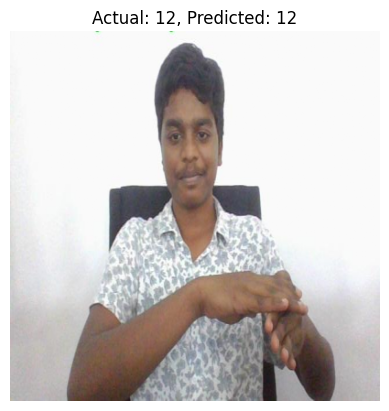

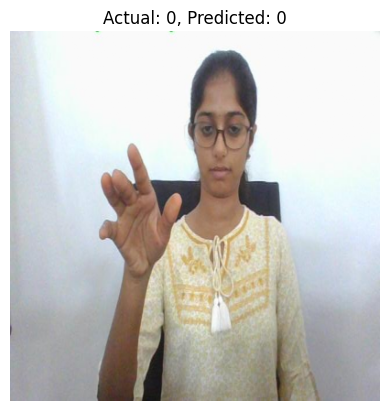

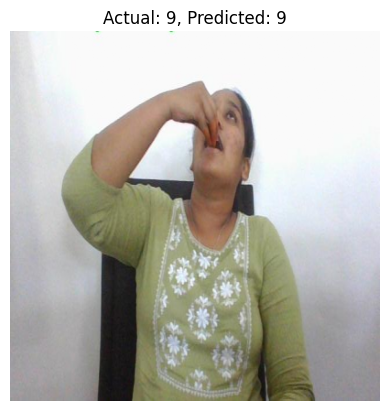

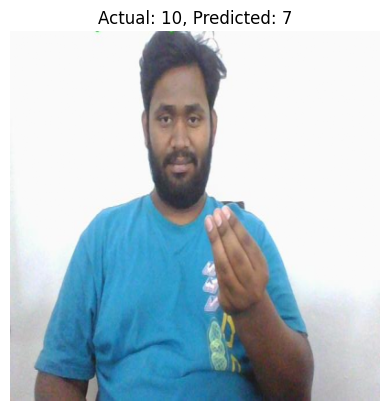

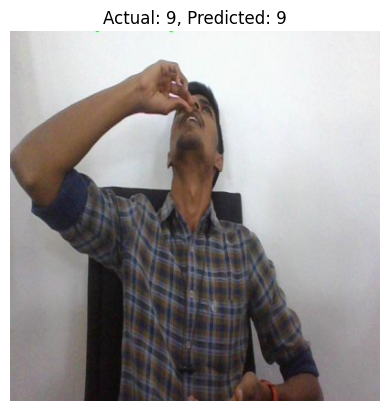

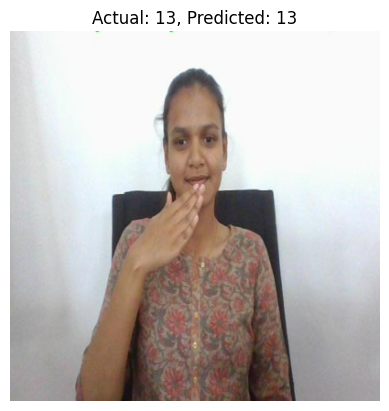

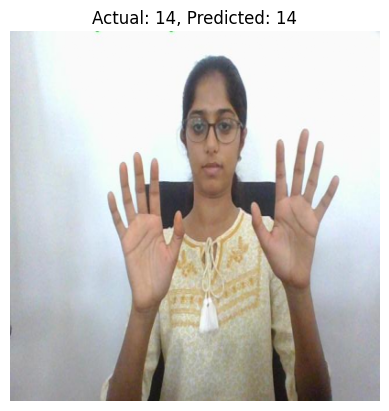

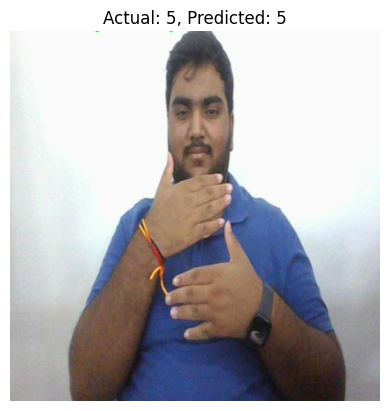

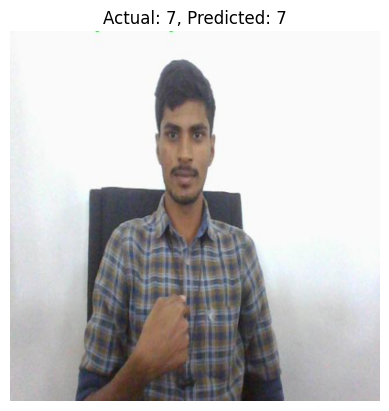

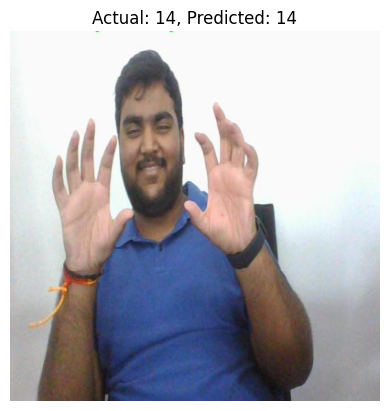

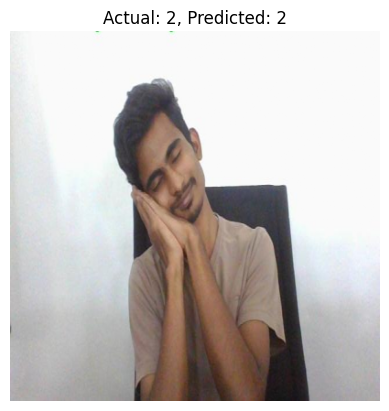

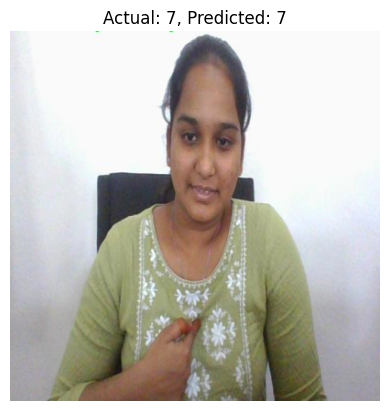

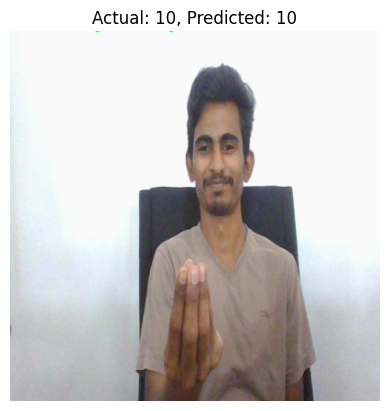

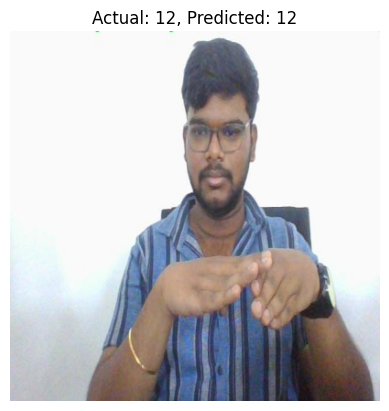

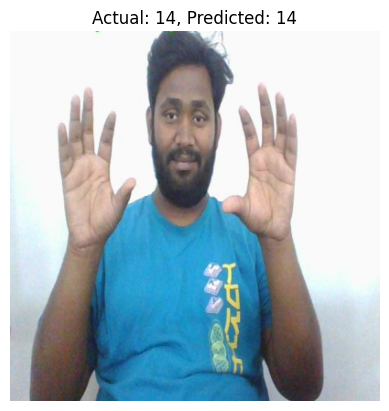

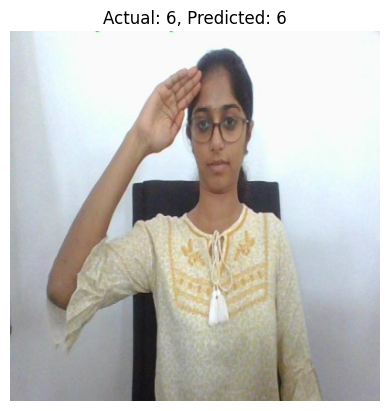

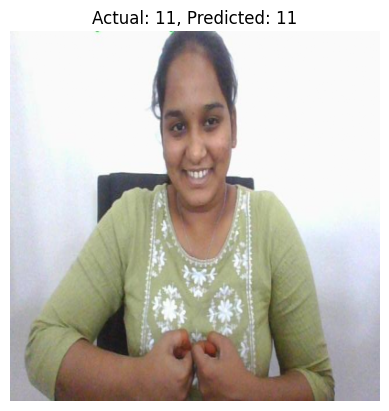

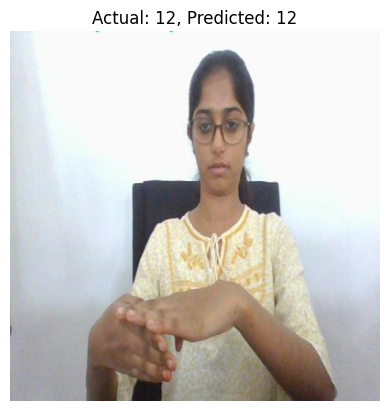

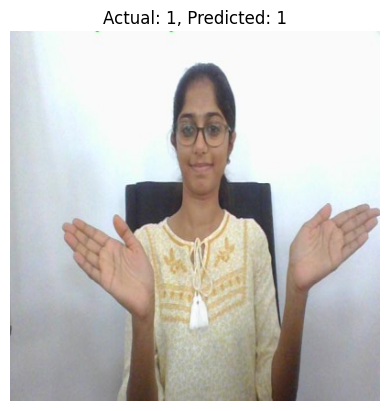

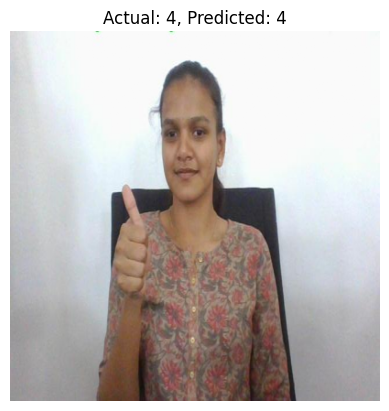

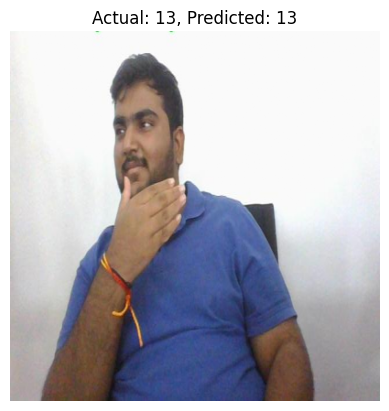

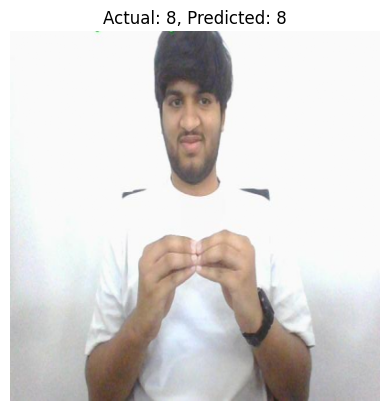

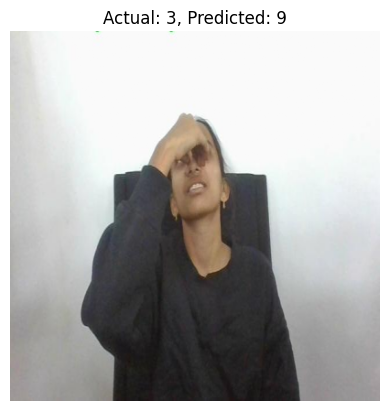

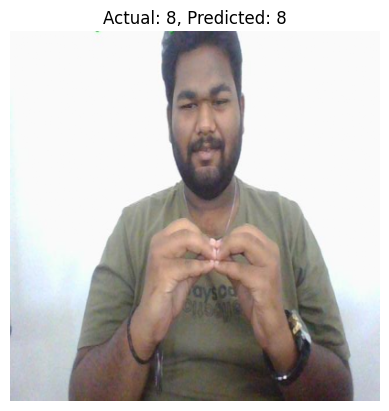

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Function to display images with actual and predicted labels
def visualize_predictions(test_loader, model):
    # Set the model to evaluation mode
    model.eval()
    
    # Iterate through the test loader
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            
            # Get predicted labels
            _, predicted = torch.max(outputs, 1)

            # Convert tensors to numpy arrays
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()
            predicted = predicted.cpu().numpy()

            # Display images with labels
            for i in range(len(images)):
                plt.imshow(np.transpose(images[i], (1, 2, 0)))  # Convert from tensor format to image format
                plt.title(f'Actual: {labels[i]}, Predicted: {predicted[i]}')
                plt.axis('off')
                plt.show()

# Visualize predictions
visualize_predictions(test_loader, model1)
